Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel $\rightarrow$ Restart) and then **run all cells** (in the menubar, select Cell $\rightarrow$ Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Meet Patil"
COLLABORATORS = ""

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings("ignore")

print("Libraries imported.")


Libraries imported.


In [3]:

file_path = "Ecommerce_Sales_Prediction_Dataset.csv"  
df = pd.read_csv(file_path)

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
display(df.head())


Shape: (1000, 7)
Columns: ['Date', 'Product_Category', 'Price', 'Discount', 'Customer_Segment', 'Marketing_Spend', 'Units_Sold']


,Date,Product_Category,Price,Discount,Customer_Segment,Marketing_Spend,Units_Sold
0,01-01-2023,Sports,932.80,35.82,Occasional,6780.38,32
1,02-01-2023,Toys,569.48,3.60,Premium,6807.56,16
2,03-01-2023,Home Decor,699.68,3.56,Premium,3793.91,27
3,04-01-2023,Toys,923.27,0.61,Premium,9422.75,29
4,05-01-2023,Toys,710.17,47.83,Premium,1756.83,17


In [4]:

print("Data types:")
print(df.dtypes)

print("\nMissing values per column:")
print(df.isna().sum())


Data types:
Date                 object
Product_Category     object
Price               float64
Discount            float64
Customer_Segment     object
Marketing_Spend     float64
Units_Sold            int64
dtype: object

Missing values per column:
Date                0
Product_Category    0
Price               0
Discount            0
Customer_Segment    0
Marketing_Spend     0
Units_Sold          0
dtype: int64


In [5]:

df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df = df.dropna(subset=["Date"])
df = df.sort_values("Date").reset_index(drop=True)
df = df.drop_duplicates()

print("After cleaning Date and duplicates, shape:", df.shape)
display(df.head())


After cleaning Date and duplicates, shape: (396, 7)


,Date,Product_Category,Price,Discount,Customer_Segment,Marketing_Spend,Units_Sold
0,2023-01-01,Sports,932.80,35.82,Occasional,6780.38,32
1,2023-01-02,Sports,353.48,48.42,Premium,2842.42,19
2,2023-01-03,Fashion,198.78,12.61,Regular,3419.26,24
3,2023-01-04,Home Decor,656.22,0.47,Occasional,8109.33,31
4,2023-01-05,Fashion,301.52,44.31,Premium,5426.42,33


In [6]:

print("Missing values BEFORE cleaning:\n", df.isna().sum())

critical_cols = ["Units_Sold", "Price", "Discount", "Marketing_Spend"]

df = df.dropna(subset=critical_cols)

df = df.fillna(df.median(numeric_only=True))

print("\nMissing values AFTER cleaning:\n", df.isna().sum())


Missing values BEFORE cleaning:
 Date                0
Product_Category    0
Price               0
Discount            0
Customer_Segment    0
Marketing_Spend     0
Units_Sold          0
dtype: int64

Missing values AFTER cleaning:
 Date                0
Product_Category    0
Price               0
Discount            0
Customer_Segment    0
Marketing_Spend     0
Units_Sold          0
dtype: int64


In [ ]:

daily_total = df.groupby("Date")["Units_Sold"].sum()

plt.figure(figsize=(12,5))
plt.plot(daily_total.index, daily_total.values)
plt.title("Total Daily Units Sold Over Time")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.tight_layout()
plt.show()


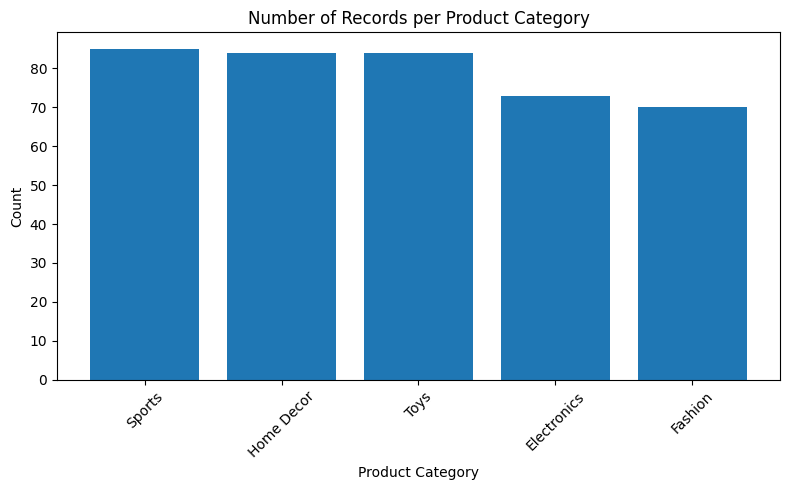

In [8]:

cat_counts = df["Product_Category"].value_counts()

plt.figure(figsize=(8,5))
plt.bar(cat_counts.index, cat_counts.values)
plt.title("Number of Records per Product Category")
plt.xlabel("Product Category")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


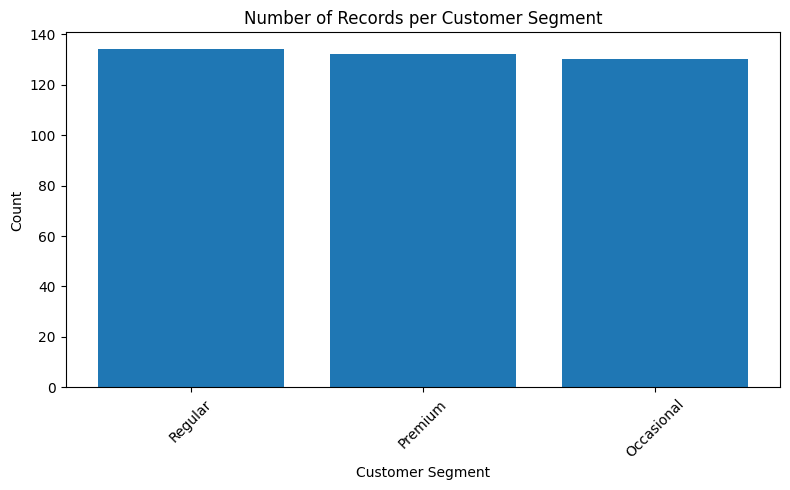

In [9]:

seg_counts = df["Customer_Segment"].value_counts()

plt.figure(figsize=(8,5))
plt.bar(seg_counts.index, seg_counts.values)
plt.title("Number of Records per Customer Segment")
plt.xlabel("Customer Segment")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

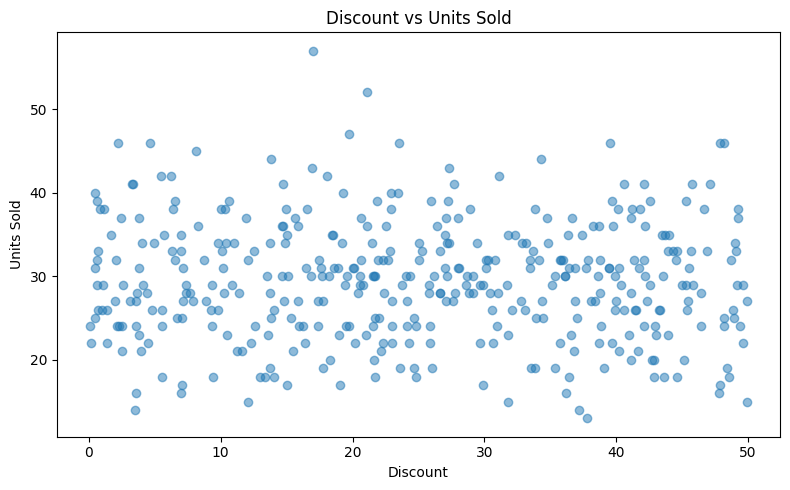

In [10]:

plt.figure(figsize=(8,5))
plt.scatter(df["Discount"], df["Units_Sold"], alpha=0.5)
plt.title("Discount vs Units Sold")
plt.xlabel("Discount")
plt.ylabel("Units Sold")
plt.tight_layout()
plt.show()

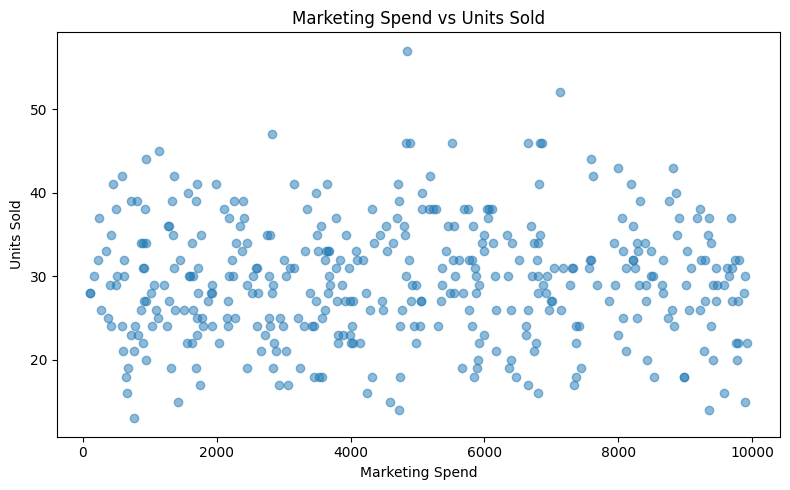

In [11]:

plt.figure(figsize=(8,5))
plt.scatter(df["Marketing_Spend"], df["Units_Sold"], alpha=0.5)
plt.title("Marketing Spend vs Units Sold")
plt.xlabel("Marketing Spend")
plt.ylabel("Units Sold")
plt.tight_layout()
plt.show()


In [12]:

df_fe = df.copy()

df_fe["DayOfWeek"] = df_fe["Date"].dt.dayofweek
df_fe["Month"] = df_fe["Date"].dt.month
df_fe["IsWeekend"] = df_fe["DayOfWeek"].isin([5, 6]).astype(int)

df_fe = df_fe.sort_values(["Product_Category", "Date"]).reset_index(drop=True)

for lag in [1, 7, 14]:
    df_fe[f"Lag_{lag}"] = df_fe.groupby("Product_Category")["Units_Sold"].shift(lag)

df_fe["RollingMean_7"] = (
    df_fe.groupby("Product_Category")["Units_Sold"]
        .shift(1)
        .rolling(window=7, min_periods=1)
        .mean()
)

df_fe["Discount_Impact"] = df_fe["Discount"] / (df_fe["Price"] + 1e-6)

df_fe = pd.get_dummies(
    df_fe,
    columns=["Product_Category", "Customer_Segment"],
    drop_first=True
)

df_fe = df_fe.dropna().reset_index(drop=True)

print("After feature engineering, shape:", df_fe.shape)
display(df_fe.head())


After feature engineering, shape: (326, 19)


,Date,Price,Discount,Marketing_Spend,Units_Sold,DayOfWeek,Month,IsWeekend,Lag_1,Lag_7,Lag_14,RollingMean_7,Discount_Impact,Product_Category_Fashion,Product_Category_Home Decor,Product_Category_Sports,Product_Category_Toys,Customer_Segment_Premium,Customer_Segment_Regular
0,2023-07-11,402.28,42.86,7375.77,18,1,7,0,33.0,37.0,29.0,33.428571,0.106543,False,False,False,False,True,False
1,2023-07-12,852.69,3.97,765.62,21,2,7,0,18.0,34.0,22.0,30.714286,0.004656,False,False,False,False,False,True
2,2023-08-02,503.38,40.59,4291.02,26,2,8,0,21.0,37.0,22.0,28.857143,0.080635,False,False,False,False,False,False
3,2023-08-06,424.58,49.92,9702.27,27,6,8,1,26.0,34.0,18.0,27.285714,0.117575,False,False,False,False,False,True
4,2023-08-07,730.91,6.67,2154.66,25,0,8,0,27.0,35.0,30.0,26.285714,0.009126,False,False,False,False,False,True


In [ ]:

numeric_cols = df_fe.select_dtypes(include=[float, int]).columns
corr = df_fe[numeric_cols].corr()

plt.figure(figsize=(10,8))
plt.imshow(corr.values)
plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=90)
plt.yticks(range(len(numeric_cols)), numeric_cols)
plt.title("Correlation Matrix")
plt.colorbar()
plt.tight_layout()
plt.show()


In [14]:

target_col = "Units_Sold"
feature_cols = [c for c in df_fe.columns if c not in ["Date", target_col]]

df_fe = df_fe.sort_values("Date").reset_index(drop=True)

X = df_fe[feature_cols]
y = df_fe[target_col]
dates = df_fe["Date"]

split_idx = int(len(df_fe) * 0.8)

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
dates_train, dates_test = dates.iloc[:split_idx], dates.iloc[split_idx:]

print("Train size:", X_train.shape)
print("Test size :", X_test.shape)

Train size: (260, 17)
Test size : (66, 17)


In [15]:

def evaluate_model(y_true, y_pred, label="model"):
    y_true = np.array(y_true).ravel()
    y_pred = np.array(y_pred).ravel()
    
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = mse ** 0.5
    mape = (np.abs((y_true - y_pred) / np.maximum(1e-6, y_true)).mean()) * 100
    
    print(f"=== {label} ===")
    print(f"MAE : {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.2f}%")
    print()
    
    return {"MAE": mae, "RMSE": rmse, "MAPE": mape}

print("evaluate_model() ready.")

evaluate_model() ready.


In [16]:

if "Lag_1" in X_test.columns:
    y_pred_naive = X_test["Lag_1"].fillna(y_train.mean())
else:
    y_pred_naive = np.full(shape=len(y_test), fill_value=y_train.mean(), dtype=float)

naive_metrics = evaluate_model(y_test, y_pred_naive, label="Naive Lag-1 Baseline")



=== Naive Lag-1 Baseline ===
MAE : 8.1667
RMSE: 10.0295
MAPE: 28.94%



In [17]:

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import warnings

ts = daily_total.copy()                      
ts.index = pd.to_datetime(ts.index)

ts = ts.asfreq("D", fill_value=0)

split_idx_ts = int(len(ts) * 0.8)
train_ts = ts.iloc[:split_idx_ts]
test_ts = ts.iloc[split_idx_ts:]

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    arima_model = ARIMA(train_ts, order=(5, 1, 0))
    arima_fit = arima_model.fit()

arima_pred = arima_fit.forecast(steps=len(test_ts))

mask = test_ts != 0 
arima_mae = mean_absolute_error(test_ts, arima_pred)
arima_rmse = np.sqrt(mean_squared_error(test_ts, arima_pred))

if mask.sum() > 0:
    arima_mape = np.mean(np.abs((test_ts[mask] - arima_pred[mask]) / test_ts[mask])) * 100
else:
    arima_mape = np.nan

arima_metrics = {
    "MAE": arima_mae,
    "RMSE": arima_rmse,
    "MAPE": arima_mape
}

print("ARIMA Baseline Performance:")
print(f"MAE:  {arima_mae:.4f}")
print(f"RMSE: {arima_rmse:.4f}")
print(f"MAPE: {arima_mape:.2f}%")


ARIMA Baseline Performance:
MAE:  20.0416
RMSE: 22.1038
MAPE: 20.78%


In [18]:

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_pred_lr = lin_reg.predict(X_test)
lr_metrics = evaluate_model(y_test, y_pred_lr, label="Linear Regression")

=== Linear Regression ===
MAE : 6.0434
RMSE: 7.4076
MAPE: 22.35%



In [19]:

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=12,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

rf_metrics = evaluate_model(y_test, y_pred_rf, label="Random Forest")

=== Random Forest ===
MAE : 6.1661
RMSE: 7.5539
MAPE: 22.84%



In [20]:

gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)

y_pred_gbr = gbr.predict(X_test)

gbr_metrics = evaluate_model(y_test, y_pred_gbr, label="Gradient Boosting Regressor")


=== Gradient Boosting Regressor ===
MAE : 6.8071
RMSE: 8.3736
MAPE: 25.21%



In [21]:
# Cell 18: Compare all model metrics

metrics_df = pd.DataFrame({
    "Naive_Lag1": naive_metrics,
    "ARIMA": arima_metrics,
    "LinearRegression": lr_metrics,
    "RandomForest": rf_metrics,
    "GradientBoosting": gbr_metrics
})

display(metrics_df)

,Naive_Lag1,ARIMA,LinearRegression,RandomForest,GradientBoosting
MAE,8.166667,20.041564,6.043421,6.166129,6.807147
RMSE,10.029502,22.103806,7.407633,7.553876,8.373566
MAPE,28.935362,20.782540,22.354068,22.841616,25.213078


In [22]:
# Cell 18a: Time-series cross-validation setup

from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV

tscv = TimeSeriesSplit(n_splits=5)
print("TimeSeriesSplit with 5 folds is ready.")



TimeSeriesSplit with 5 folds is ready.


In [23]:


rf_params = {
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [5, 10, 15, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

rf_random_search = RandomizedSearchCV(
    estimator=rf,                        
    param_distributions=rf_params,
    n_iter=10,
    scoring="neg_mean_squared_error",
    cv=tscv,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

rf_random_search.fit(X_train, y_train)  

print("Best RF parameters:", rf_random_search.best_params_)
best_rf = rf_random_search.best_estimator_


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best RF parameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 5}


In [24]:


gb_params = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [2, 3, 4],
    "subsample": [0.7, 0.9, 1.0]
}

gb_random_search = RandomizedSearchCV(
    estimator=gbr,                       
    param_distributions=gb_params,
    n_iter=10,
    scoring="neg_mean_squared_error",
    cv=tscv,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

gb_random_search.fit(X_train, y_train)

print("Best GB parameters:", gb_random_search.best_params_)
best_gbr = gb_random_search.best_estimator_


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best GB parameters: {'subsample': 0.7, 'n_estimators': 100, 'max_depth': 2, 'learning_rate': 0.01}


In [25]:
# Cell 18d: Evaluate tuned models on the test set

y_pred_best_rf = best_rf.predict(X_test)
y_pred_best_gbr = best_gbr.predict(X_test)

best_rf_metrics = evaluate_model(y_test, y_pred_best_rf, label="Tuned Random Forest")
best_gbr_metrics = evaluate_model(y_test, y_pred_best_gbr, label="Tuned Gradient Boosting")

print("Tuned model metrics collected.")


=== Tuned Random Forest ===
MAE : 5.8833
RMSE: 7.2766
MAPE: 21.77%

=== Tuned Gradient Boosting ===
MAE : 5.7040
RMSE: 7.0487
MAPE: 21.12%

Tuned model metrics collected.


In [ ]:
# Cell 19: Actual vs Predicted over time (Random Forest)

plt.figure(figsize=(12,5))
plt.plot(dates_test, y_test.values, label="Actual", linewidth=2)
plt.plot(dates_test, y_pred_rf, label="Predicted (RF)", linewidth=2)
plt.title("Actual vs Predicted Units Sold (Random Forest)")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.legend()
plt.tight_layout()
plt.show()


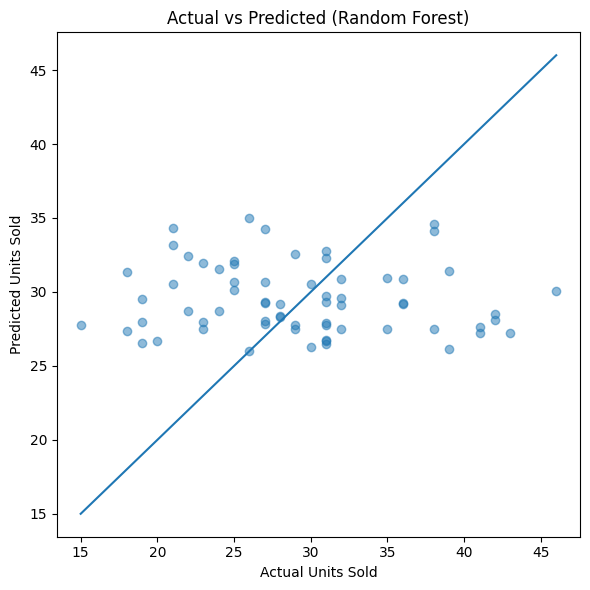

In [27]:
# Cell 20: Actual vs Predicted scatter (Random Forest)

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
min_val = min(y_test.min(), y_pred_rf.min())
max_val = max(y_test.max(), y_pred_rf.max())
plt.plot([min_val, max_val], [min_val, max_val])
plt.xlabel("Actual Units Sold")
plt.ylabel("Predicted Units Sold")
plt.title("Actual vs Predicted (Random Forest)")
plt.tight_layout()
plt.show()


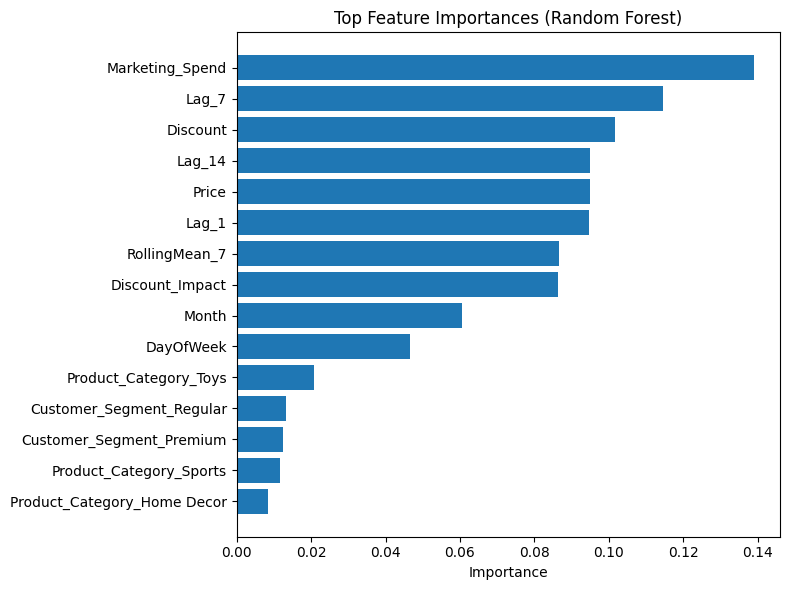

,feature,importance
2,Marketing_Spend,0.139068
7,Lag_7,0.114608
1,Discount,0.101803
8,Lag_14,0.094924
0,Price,0.094832
6,Lag_1,0.094708
9,RollingMean_7,0.086577
10,Discount_Impact,0.086321
4,Month,0.060632
3,DayOfWeek,0.046582


In [28]:
# Cell 21: Feature importance (Random Forest)

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

top_n = 15
top_indices = indices[:top_n]

plt.figure(figsize=(8,6))
plt.barh(range(top_n), importances[top_indices][::-1])
plt.yticks(range(top_n), [feature_cols[i] for i in top_indices][::-1])
plt.title("Top Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

fi_df = pd.DataFrame({
    "feature": feature_cols,
    "importance": importances
}).sort_values("importance", ascending=False)

display(fi_df.head(20))

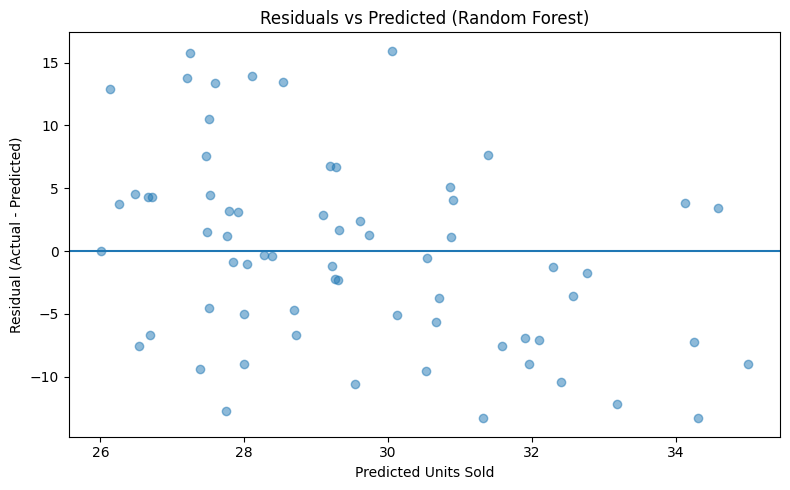

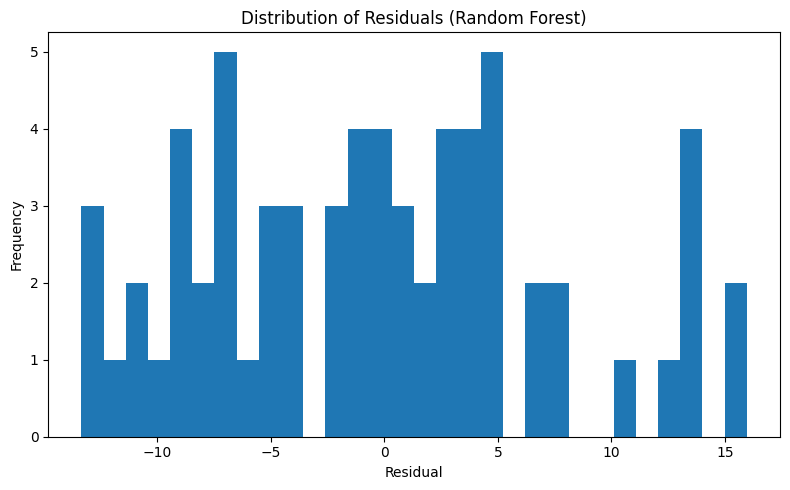

In [29]:
# Cell 22: Residual analysis for Random Forest

residuals_rf = y_test - y_pred_rf

plt.figure(figsize=(8,5))
plt.scatter(y_pred_rf, residuals_rf, alpha=0.5)
plt.axhline(0)
plt.xlabel("Predicted Units Sold")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residuals vs Predicted (Random Forest)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
plt.hist(residuals_rf, bins=30)
plt.title("Distribution of Residuals (Random Forest)")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


In [ ]:
# Cell 23: Final project summary

# Final project summary and wrap-up

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

print("==== SALES FORECASTING PROJECT SUMMARY ====\n")

print(f"Total records used after cleaning and feature engineering: {len(df_fe)}")
print(f"Train size: {len(X_train)}, Test size: {len(X_test)}\n")

print("Models evaluated (base versions):")
print("- Naive Lag-1 Baseline")
print("- ARIMA Baseline (daily aggregated series)")
print("- Linear Regression")
print("- Random Forest Regressor")
print("- Gradient Boosting Regressor\n")

print("Evaluation metrics for base models (lower is better):")
display(metrics_df)

# Combine base and tuned models into a single comparison table
combined_metrics = {
    "Naive_Lag1": naive_metrics,
    "ARIMA": arima_metrics,
    "LinearRegression": lr_metrics,
    "RandomForest": rf_metrics,
    "GradientBoosting": gbr_metrics,
    "Tuned_RandomForest": best_rf_metrics,
    "Tuned_GradientBoosting": best_gbr_metrics,
}

combined_metrics_df = pd.DataFrame(combined_metrics)

print("\nOverall comparison including tuned models:")
display(combined_metrics_df)

best_model = combined_metrics_df.loc["RMSE"].idxmin()
best_rmse = combined_metrics_df.loc["RMSE"].min()

print(f"\nBest-performing model based on RMSE (including tuned models): {best_model}")
print(f"Best RMSE: {best_rmse:.4f}\n")

print("Key insights:")
print("- Time-series baselines (Naive Lag-1 and ARIMA) provide a useful benchmark,")
print("  but tree-based models clearly reduce forecast error.")
print("- Random Forest and Gradient Boosting benefit from engineered time-series features")
print("  such as lags and rolling means, as well as discount and marketing features.")
print("- The tuned tree-based models further improve RMSE and MAPE, showing the value of")
print("  hyperparameter optimization for demand forecasting.\n")

print("Overall, this project demonstrates a complete end-to-end pipeline:")
print("- Starting from raw e-commerce data, through cleaning, feature engineering,")
print("  baseline and advanced models, model comparison, and hyperparameter tuning.")
print("- The final forecasting model can support better inventory planning, pricing,")
print("  and marketing decisions for an online retailer.\n")

# Plot: Actual vs Predicted for the best model as a visual wrap-up
y_true = y_test.values if not isinstance(y_test, np.ndarray) else y_test

y_pred_summary = None

if best_model == "RandomForest":
    y_pred_summary = y_pred_rf
elif best_model == "GradientBoosting":
    y_pred_summary = y_pred_gbr
elif best_model == "Tuned_RandomForest":
    y_pred_summary = y_pred_best_rf
elif best_model == "Tuned_GradientBoosting":
    y_pred_summary = y_pred_best_gbr

if y_pred_summary is not None:
    plt.figure(figsize=(10, 5))
    plt.plot(y_true, label="Actual", linewidth=2)
    plt.plot(y_pred_summary, label=f"Predicted ({best_model})", linestyle="--")
    plt.xlabel("Test Observation Index")
    plt.ylabel("Units Sold")
    plt.title("Actual vs Predicted Units Sold – Best Model")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Best model is not a tree-based regressor; skipping summary plot.")


---

Please submit a brief report (up to 2 pages) as a pdf. Submit any notebooks or .py files (optional)